<a href="https://colab.research.google.com/github/ihagoSantos/deep_learning/blob/main/knn_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset CIFAR-10


In [ ]:
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz

--2024-10-03 09:26:33--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  34.3MB/s    in 5.0s    

2024-10-03 09:26:39 (32.3 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


# Basic Initializing

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from past.builtins import xrange

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2


# Load Data

In [ ]:
from six.moves import cPickle as pickle
import os
import platform

def load_pickle(f):
  version = platform.python_version_tuple()
  if version[0] == '2':
    return pickle.load(f)
  elif version[0] == '3':
    return pickle.load(f, encoding='latin1')
  raise ValueError('invalid python version: {}'.format(version))

def load_CIFAR_batch(filename):
  """
  load single batch of cifar
  """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X,Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)

  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X,Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

In [ ]:
cifar10_dir = 'cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [ ]:
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


# Sample Data Visualization

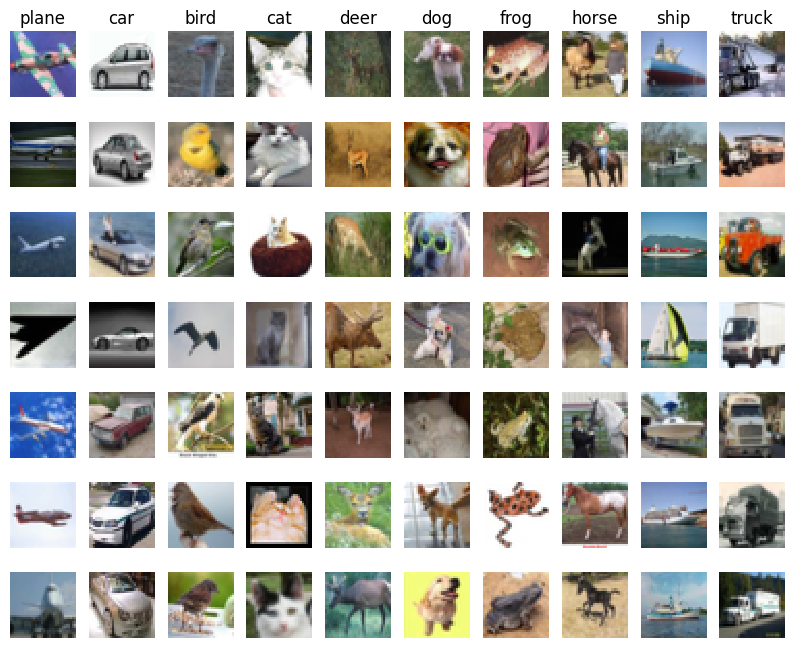

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# Data Preparation

In [ ]:
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


# Implementing kNN Classifier

In [ ]:
class KNearestNeighbor(object):
  """ a kNN Classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest-neighbors this is just memorizing the train data.

    Inputs:
    - X: A numpy array of shape (num_train, D) contaning the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
      y[i] is the label for X[i]

    """
    self.X_train = X
    self.y_train = y

  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loop(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the
    test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))

    for i in xrange(num_test):
      for j in xrange(num_train):
        dists[i,j] = np.sqrt(np.sum(np.square(self.X_train[j] - X[i])))
    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in xrange(num_test):
      dists[i, :] = np.sqrt(np.sum(np.square(self.X_train - X[i, :]), axis = 1))
    return dists

  def compute_distances_no_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    x2 = np.sum(X**2, axis=1).reshape((num_test,1))
    y2 = np.sum(self.X_train**2, axis=1).reshape((1,num_train))
    xy = X.dot(self.X_train.T)
    dists = np.sqrt(x2+y2-2*xy)
    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.

    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in xrange(num_test):
      closest_y = []
      closest_y = self.y_train[np.argsort(dists[i,:])[:k]]
      y_pred[i] = np.argmax(np.bincount(closest_y))

    return y_pred

In [ ]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [ ]:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

# Vizualizing Distance Matrix of kNN Classifier

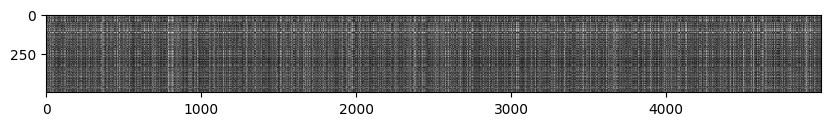

In [ ]:
plt.imshow(dists, interpolation='none')
plt.show()

# Predicting data with kNN Classifier

In [ ]:
# calculating accuracy with 1-nearest-neighbor
y_test_pred = classifier.predict_labels(dists, k=1)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print("Got %d / %d correct => accuracy: %f" % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [ ]:
# calculating accuracy with 5-nearest-neighbor
y_test_pred = classifier.predict_labels(dists, k=5)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print("Got %d / %d correct => accuracy: %f" % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


# Exploring paralelism for increasing performace

Using vectors operations to trying to increase performance. First of all, eliminate one of two loops:

In [ ]:
# First, let's speed up the distance matrix computation by parallelizing one of the loops. The implementation is found in the compute_distances_one_loop function inside the KNearestNeighbor class.

dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that your parallelized implementation is correct, you must verify that its result matches that of the naive (or trivial) implementation.

# There are several ways to decide whether two matrices are similar; one of the simplest is the Frobenius norm.
# In case you're not familiar with it, the Frobenius norm of two matrices is the square root of the sum of the squares of the differences between all corresponding elements of the two matrices.
# In other words, it's like reformatting the matrices as vectors and calculating the Euclidean distance between them.

difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))

if difference < 0.001:
  print('Good! The distance matrices are the same')
else:
  print('Uh-oh! The distance matrices are different')


Difference was: 0.000000
Good! The distance matrices are the same


## Comparing the efficience of the three implementations

In [ ]:
def time_function(f, *args):
  """Chama uma função f com args e retorna o tempo (em segundos) que ela levou para executar."""
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print("Two loop version took %f seconds " % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print("One loop version took %f seconds " % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loop, X_test)
print("No loop version took %f seconds " % no_loop_time)

# NOTE: You should see significantly faster execution with the fully vectorized implementation.

Two loop version took 36.920147 seconds 
One loop version took 61.677326 seconds 
No loop version took 0.627827 seconds 


# Cross Validation

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

k_to_accuracies = {}

In [ ]:
X_train_folds = np.array_split(X_train, num_folds)
len(X_train_folds)

5

In [ ]:
y_train_folds = np.array_split(y_train, num_folds)
len(y_train_folds)

5

In [ ]:
for k in k_choices:
  k_to_accuracies[k] = []
  for i in range(num_folds):
    training_data, test_data = np.concatenate(X_train_folds[:i] + X_train_folds[i+1:]), X_train_folds[i]
    training_labels, test_labels = np.concatenate(y_train_folds[:i] + y_train_folds[i+1:]), y_train_folds[i]
    classifier.train(training_data, training_labels)
    predicted_labels = classifier.predict(test_data, k)
    k_to_accuracies[k].append(np.sum(predicted_labels == test_labels)/ len(test_labels))


{1: [0.263, 0.257, 0.264, 0.278, 0.266], 3: [0.239, 0.249, 0.24, 0.266, 0.254], 5: [0.248, 0.266, 0.28, 0.292, 0.28], 8: [0.262, 0.282, 0.273, 0.29, 0.273], 10: [0.265, 0.296, 0.276, 0.284, 0.28], 12: [0.26, 0.295, 0.279, 0.283, 0.28], 15: [0.252, 0.289, 0.278, 0.282, 0.274], 20: [0.27, 0.279, 0.279, 0.282, 0.285], 50: [0.271, 0.288, 0.278, 0.269, 0.266], 100: [0.256, 0.27, 0.263, 0.256, 0.263]}


In [ ]:
# show the accuracies
for k in sorted(k_to_accuracies):
  for accuracy in k_to_accuracies[k]:
    print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

# Plotting Results

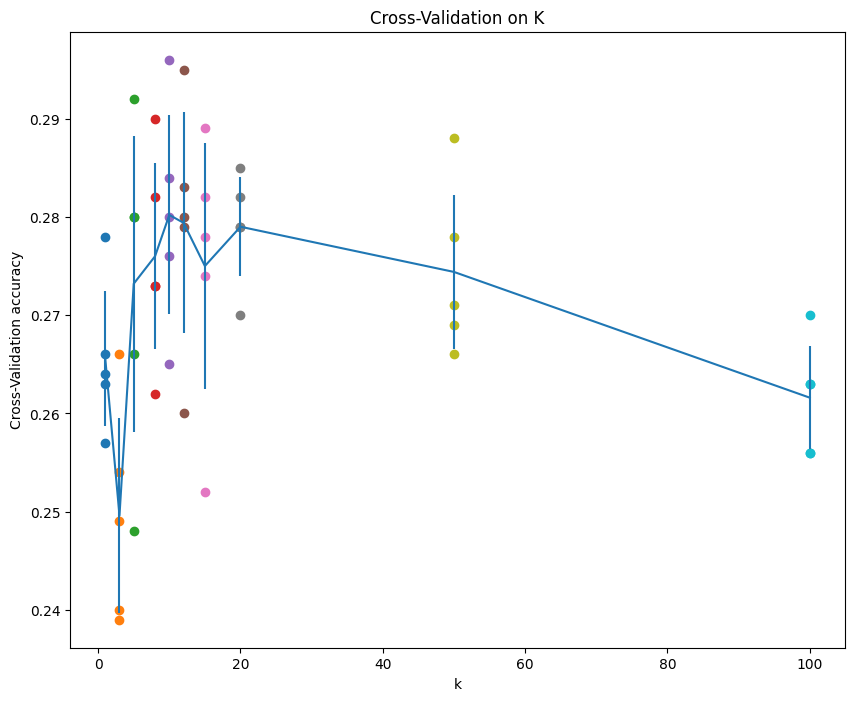

In [ ]:
# plotting brute observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plots trendlines with error bars corresponding to the standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title("Cross-Validation on K")
plt.xlabel('k')
plt.ylabel("Cross-Validation accuracy")
plt.show()

# Selecting the best value for k and training the classifier

In [ ]:
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# calculate and show accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000
